---
# 1) Resumo

Neste notebook foram feitos os treinamentos e seleção de hyperparamentros de 6 modelos de **ML** distintos. Os modelos estudados foram:

* DummyClassifier
* LogisticRegression
* DecisionTreeClassifier
* Forest Tree
* Support Vector Machine
* KNeighbors

A busca pelos hyperparametros foram feitas pelo GridSearchCV ou pelo RandomizedSearchCV. Para a Cross Validation foi usado **RepeatedStratifiedKFold** com **5** divições de **10** repetições.

O parametro utilizado para avaliação do modelo for **ROC_AUC** e quantidade de **falsos negativos** (FN).

A base de dados utilizados tem **351** amostras com **52** variaveis explicativas. Dessas **351** amostras **298** foram usados para **Cross Validation** (treino + teste) e **53** foram usados para a **validação**.


---
# 2) Pre-analise

## 2.1) Importando libs

In [36]:
collab=True
if (collab):
  !pip install matplotlib==3.4.2
  !wget "https://raw.githubusercontent.com/HenriqueCCdA/BC_DS_Projeto_Final/main/src/plota_graficos.py"
  !wget "https://raw.githubusercontent.com/HenriqueCCdA/BC_DS_Projeto_Final/main/src/ml.py"
  !wget "https://raw.githubusercontent.com/HenriqueCCdA/BC_DS_Projeto_Final/main/src/info.py"

  from plota_graficos import plota_treino_teste_auc
  from ml import retorna_x_y, intervalo_de_confianca, treina_modelo_grid_search_cv,\
                 treina_modelo_randomized_search_cv, obtem_os_resultados_SearchCV, cv_val_split 

  from info import proporcao_y, porcentagem_teste_treino_val, resultados_treinamento, dimensao_dados

else:
  import sys
  sys.path.insert(1, "../../")

  from src.plota_graficos import plota_treino_teste_auc
  from src.ml import retorna_x_y, intervalo_de_confianca, treina_modelo_grid_search_cv,\
                   treina_modelo_randomized_search_cv, obtem_os_resultados_SearchCV, cv_val_split 

  from src.info import proporcao_y, porcentagem_teste_treino_val, resultados_treinamento, dimensao_dados

--2021-08-03 02:34:47--  https://raw.githubusercontent.com/HenriqueCCdA/BC_DS_Projeto_Final/main/src/plota_graficos.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6320 (6.2K) [text/plain]
Saving to: ‘plota_graficos.py.1’

plota_graficos.py.1 100%[===================>]   6.17K  --.-KB/s    in 0s      

2021-08-03 02:34:47 (57.9 MB/s) - ‘plota_graficos.py.1’ saved [6320/6320]

--2021-08-03 02:34:47--  https://raw.githubusercontent.com/HenriqueCCdA/BC_DS_Projeto_Final/main/src/ml.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length:

## 2.2) Minhas Funções

In [2]:
import pandas as pd
#
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
#
import matplotlib.pyplot as plt
#
import numpy as np
#
from scipy.stats import uniform

---
# 3) Lendo os dados

In [40]:
path = "https://raw.githubusercontent.com/HenriqueCCdA/BC_DS_Projeto_Final/main/Dados/Tratados/dados_sem_coor_acima_do_valor_de_corte.csv"

dados_com_corte = pd.read_csv(path)

dimensao_dados(dados_com_corte)

dados_com_corte.tail(n=5)

Numero de linhas : 351 
Numero de colunas: 53 


,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,BE_ARTERIAL_MEDIAN,BE_VENOUS_MEDIAN,BIC_VENOUS_MEDIAN,BILLIRUBIN_MEDIAN,BLAST_MEDIAN,CALCIUM_MEDIAN,CREATININ_MEDIAN,FFA_MEDIAN,GGT_MEDIAN,GLUCOSE_MEDIAN,HEMATOCRITE_MEDIAN,INR_MEDIAN,LACTATE_MEDIAN,LEUKOCYTES_MEDIAN,LINFOCITOS_MEDIAN,P02_ARTERIAL_MEDIAN,P02_VENOUS_MEDIAN,PC02_ARTERIAL_MEDIAN,PC02_VENOUS_MEDIAN,PCR_MEDIAN,PH_ARTERIAL_MEDIAN,PH_VENOUS_MEDIAN,PLATELETS_MEDIAN,POTASSIUM_MEDIAN,SAT02_ARTERIAL_MEDIAN,SAT02_VENOUS_MEDIAN,SODIUM_MEDIAN,TGO_MEDIAN,TGP_MEDIAN,TTPA_MEDIAN,UREA_MEDIAN,DIMER_MEDIAN,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MAX,ICU
346,0,-0.333333,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.578947,-1.0,-1.000000,-0.317073,-0.293564,-1.0,0.326531,-0.937721,1.000000,-0.147196,-0.824953,-0.253669,-0.806775,1.000000,-0.704519,-0.879668,-0.170732,-0.704142,-0.77931,-0.754601,-0.565974,0.234043,0.363636,-0.895861,-0.629630,0.939394,0.345679,-0.428571,-0.925725,-0.981326,-0.629428,-0.860241,-0.978029,-0.160494,-0.692308,0.339623,-0.457627,0.142857,0.736842,-0.418803,1
347,1,1.000000,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.605263,-1.0,-1.000000,-0.317073,-0.938950,-1.0,0.285714,-0.886766,-0.742004,-0.958528,-0.891993,-0.241090,-0.959849,1.000000,-0.794129,-0.921162,-0.170732,-0.704142,-0.77931,-0.754601,-0.993195,0.234043,0.363636,-0.516689,-0.518519,0.939394,0.345679,-0.314286,-0.998507,-0.995808,-0.846633,-0.855422,-0.978029,-0.407407,-0.692308,-0.283019,-0.457627,-0.059524,0.526316,-0.589744,0
348,0,-0.111111,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.605263,-1.0,-1.000000,-0.317073,-0.938950,-1.0,0.357143,-0.905166,-0.742004,-0.958528,-0.891993,0.064990,-0.959849,1.000000,-0.718038,-0.838174,-0.170732,-0.704142,-0.77931,-0.754601,-0.034405,0.234043,0.363636,-0.658211,-0.407407,0.939394,0.345679,-0.085714,-0.995428,-0.986662,-0.846633,-0.787952,-0.964461,0.012346,-0.384615,-0.320755,-0.457627,-0.071429,0.894737,-0.299145,1
349,0,-0.333333,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.605263,-1.0,-1.000000,-0.317073,-0.938950,-1.0,0.357143,-0.922151,-0.742004,-0.958528,-0.843575,-0.069182,-0.959849,1.000000,-0.877559,-0.819502,-0.170732,-0.704142,-0.77931,-0.754601,-0.804159,0.234043,0.363636,-0.623498,-0.555556,0.939394,0.345679,0.085714,-0.995428,-0.986662,-0.846633,-0.937349,-0.978029,0.086420,-0.230769,-0.301887,-0.661017,-0.107143,0.736842,-0.247863,0
350,0,-0.111111,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,-1.0,-0.717277,-0.170732,-0.982208,-1.0,0.244898,-0.934890,-0.782516,-0.960280,-0.862197,-0.064990,-0.957340,-0.897773,-0.848590,-0.686722,-0.170732,-0.857988,-0.77931,-0.730061,-0.906238,0.234043,0.424242,-0.479306,-0.333333,0.939394,-0.333333,-0.085714,-0.997387,-0.992378,-0.869210,-0.879518,-0.979571,0.012346,-0.292308,0.056604,-0.525424,0.535714,0.789474,-0.299145,0


In [4]:
dados_com_corte.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 351 entries, 0 to 350
Data columns (total 53 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   AGE_ABOVE65                   351 non-null    int64  
 1   AGE_PERCENTIL                 351 non-null    float64
 2   GENDER                        351 non-null    int64  
 3   DISEASE GROUPING 1            351 non-null    float64
 4   DISEASE GROUPING 2            351 non-null    float64
 5   DISEASE GROUPING 3            351 non-null    float64
 6   DISEASE GROUPING 4            351 non-null    float64
 7   DISEASE GROUPING 5            351 non-null    float64
 8   DISEASE GROUPING 6            351 non-null    float64
 9   HTN                           351 non-null    float64
 10  IMMUNOCOMPROMISED             351 non-null    float64
 11  OTHER                         351 non-null    float64
 12  ALBUMIN_MEDIAN                351 non-null    float64
 13  BE_AR

In [5]:
dados_com_corte.describe()

,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,BE_ARTERIAL_MEDIAN,BE_VENOUS_MEDIAN,BIC_VENOUS_MEDIAN,BILLIRUBIN_MEDIAN,BLAST_MEDIAN,CALCIUM_MEDIAN,CREATININ_MEDIAN,FFA_MEDIAN,GGT_MEDIAN,GLUCOSE_MEDIAN,HEMATOCRITE_MEDIAN,INR_MEDIAN,LACTATE_MEDIAN,LEUKOCYTES_MEDIAN,LINFOCITOS_MEDIAN,P02_ARTERIAL_MEDIAN,P02_VENOUS_MEDIAN,PC02_ARTERIAL_MEDIAN,PC02_VENOUS_MEDIAN,PCR_MEDIAN,PH_ARTERIAL_MEDIAN,PH_VENOUS_MEDIAN,PLATELETS_MEDIAN,POTASSIUM_MEDIAN,SAT02_ARTERIAL_MEDIAN,SAT02_VENOUS_MEDIAN,SODIUM_MEDIAN,TGO_MEDIAN,TGP_MEDIAN,TTPA_MEDIAN,UREA_MEDIAN,DIMER_MEDIAN,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MAX,ICU
count,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000
mean,0.458689,-0.046534,0.381766,0.108262,0.022792,0.091168,0.019943,0.128205,0.045584,0.196581,0.162393,0.811966,0.571900,-0.988680,-0.953730,-0.315266,-0.944913,-0.993560,0.328537,-0.892237,-0.728446,-0.932584,-0.856478,-0.119234,-0.942741,0.494624,-0.761648,-0.744157,-0.175266,-0.692577,-0.778151,-0.760963,-0.823305,0.236346,0.375982,-0.505947,-0.556822,0.928559,0.301959,-0.088807,-0.993806,-0.986840,-0.828954,-0.841746,-0.960159,-0.045990,-0.318411,-0.240403,-0.468207,0.097772,0.760029,-0.313074,0.461538
std,0.499002,0.640366,0.486513,0.311155,0.149453,0.288259,0.140004,0.334795,0.208879,0.397980,0.369338,0.391297,0.146607,0.086813,0.128238,0.090419,0.043857,0.107614,0.088826,0.099423,0.165901,0.147390,0.097183,0.226253,0.041537,0.837465,0.158005,0.153140,0.089491,0.128432,0.017829,0.051315,0.241212,0.047356,0.091409,0.209888,0.170066,0.115542,0.320451,0.208983,0.017485,0.015381,0.080423,0.135197,0.098682,0.253692,0.274796,0.278347,0.213326,0.272230,0.116880,0.185592,0.499230
min,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.578947,-1.000000,-1.000000,-1.000000,-0.994767,-1.000000,-0.040816,-0.978769,-0.918977,-0.997664,-1.000000,-1.000000,-1.000000,-0.992765,-1.000000,-1.000000,-1.000000,-1.000000,-0.862069,-1.000000,-1.000000,-0.319149,-0.090909,-1.000000,-1.000000,-1.000000,-1.000000,-0.828571,-1.000000,-0.999619,-0.961853,-0.971084,-1.000000,-0.654321,-0.938462,-0.823899,-0.954802,-0.571429,0.263158,-0.760684,0.000000
25%,0.000000,-0.555556,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.605263,-1.000000,-1.000000,-0.317073,-0.963370,-1.000000,0.336735,-0.930644,-0.742004,-0.958528,-0.891993,-0.247379,-0.959849,-0.793745,-0.843183,-0.846473,-0.170732,-0.704142,-0.779310,-0.754601,-0.982231,0.234043,0.363636,-0.642190,-0.666667,0.939394,0.345679,-0.200000,-0.996921,-0.994665,-0.846633,-0.898795,-0.983811,-0.185185,-0.538462,-0.415094,-0.593220,-0.107143,0.684211,-0.418803,0.000000
50%,0.000000,-0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.605263,-1.000000,-1.000000,-0.317073,-0.938950,-1.000000,0.357143,-0.908402,-0.742004,-0.958528,-0.891993,-0.102725,-0.959849,1.000000,-0.795288,-0.790456,-0.170732,-0.704142,-0.779310,-0.754601,-0.906238,0.234043,0.363636,-0.540721,-0.555556,0.939394,0.345679,-0.085714,-0.995428,-0.988567,-0.846633,-0.874699,-0.978029,-0.037037,-0.369231,-0.283019,-0.525424,0.071429,0.789474,-0.299145,0.000000


In [6]:
x_cv, x_val, y_cv, y_val = cv_val_split(dados_com_corte, p_val = .15)

In [7]:
proporcao_y(dados_com_corte['ICU'])
proporcao_y(y_val)
proporcao_y(y_cv )

Proporcao do ICU
Campo 0 ->  53.85%
Campo 1 ->  46.15%
Proporcao do ICU
Campo 0 ->  54.72%
Campo 1 ->  45.28%
Proporcao do ICU
Campo 0 ->  53.69%
Campo 1 ->  46.31%


In [8]:
porcentagem_teste_treino_val(dados_com_corte['ICU'], y_val, y_cv)

Número total de entradas                         : 351
Número total de entradas para validacao          : 53
Número total de entradas para o Cross Validation : 298


# 4) Modelo de ML

A opção **refit** foi deixado como **true** logo depois que o melhor modelo for selecioando o RandomizedSearchCV/GridSearchCv **re-treina** esse modelo com o dataset completo (treino+teste). 

## 4.1) DummyClassifier

> Aqui será treinado do modelo **DummyClassifier**. Para o treino foi usado **GridSearchCV**. O único hyperparametro disponivel foi **strategy**. O intervalor de busca  **[stratified, 'ost_frequent, prior, 'uniform]**. O DummyClassifier será usado como o nosso modelo **"baseline"**



In [9]:
modelo = DummyClassifier(random_state=141715)

parameters = {'strategy' : ['stratified', 'most_frequent', 'prior', 'uniform']}

resultados, melhor_modelo_dummy, melhores_hyperparametros  = treina_modelo_grid_search_cv(modelo,
                                                                                      x_cv,
                                                                                      y_cv,
                                                                                      parameters,
                                                                                      n_splits=5,
                                                                                      n_repeats=10,
                                                                                      seed=14715)

resultados_treinamento(resultados, melhor_modelo_dummy, melhores_hyperparametros)

Fitting 50 folds for each of 4 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


melhores hyperparametros : {'strategy': 'most_frequent'}
Melhor modelo            : DummyClassifier(constant=None, random_state=141715, strategy='most_frequent')


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.9s finished


,paramentros,media_teste,media_treino,std_teste,std_treino,mean_fit_time,std_fit_time,mean_score_time,std_score_time,rank_test_score
0,{'strategy': 'stratified'},0.49769,0.504366,0.059657,0.032031,0.001061,0.000331,0.001732,0.000749,4
1,{'strategy': 'most_frequent'},0.50000,0.500000,0.000000,0.000000,0.000995,0.000170,0.001426,0.000235,1
2,{'strategy': 'prior'},0.50000,0.500000,0.000000,0.000000,0.000918,0.000113,0.001351,0.000223,1
3,{'strategy': 'uniform'},0.50000,0.500000,0.000000,0.000000,0.001062,0.000257,0.001544,0.000404,1


---
## 4.2) Regreção logistica

> Aqui será treinado do modelo **LogisticRegression**. No treino foi usado **RandomizedSearchCV** com **50** iterações. Os hyperparametros foram:
* C             : [0, 2]


Fitting 50 folds for each of 50 candidates, totalling 2500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2500 out of 2500 | elapsed:  1.6min finished


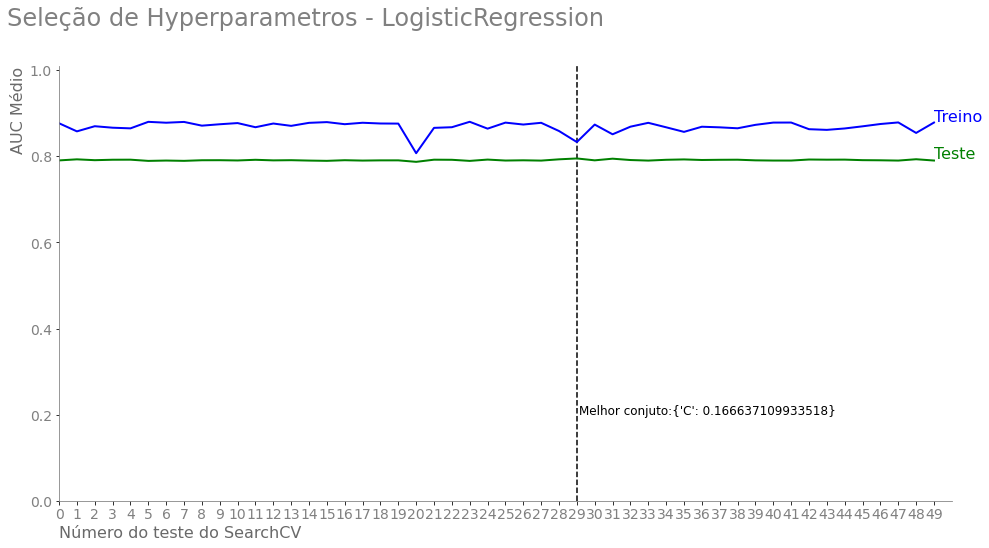

melhores hyperparametros : {'C': 0.166637109933518}
Melhor modelo            : LogisticRegression(C=0.166637109933518, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=1e-06, verbose=0,
                   warm_start=False)


,paramentros,media_teste,media_treino,std_teste,std_treino,mean_fit_time,std_fit_time,mean_score_time,std_score_time,rank_test_score
0,{'C': 2.9403726439047437},0.790546,0.876829,0.048386,0.009416,0.039011,0.007333,0.003425,0.001109,34
1,{'C': 0.8236321513787566},0.793040,0.858010,0.048955,0.010345,0.022006,0.005315,0.003163,0.000126,5
2,{'C': 1.8107081253404766},0.791085,0.869952,0.048055,0.009832,0.029670,0.005262,0.003218,0.000422,22
3,{'C': 1.4507591152545065},0.792110,0.866507,0.047840,0.009958,0.027189,0.004391,0.003189,0.000181,14
4,{'C': 1.3163817298661398},0.792241,0.865002,0.048074,0.009960,0.025593,0.003939,0.003156,0.000135,11
5,{'C': 3.7627108804741063},0.789430,0.880134,0.048696,0.009485,0.041171,0.006180,0.003149,0.000097,49
6,{'C': 3.2348466053974367},0.790225,0.878085,0.048669,0.009432,0.039282,0.007946,0.003183,0.000284,38
7,{'C': 3.6987640689695644},0.789521,0.879920,0.048761,0.009470,0.040681,0.007247,0.003237,0.000339,47
8,{'C': 1.9704679412547428},0.790928,0.871260,0.048193,0.009801,0.033030,0.005991,0.003211,0.000159,26
9,{'C': 2.4854242092996466},0.791040,0.874522,0.047977,0.009461,0.034045,0.005263,0.003207,0.000241,24


In [116]:
parameters = {'C': uniform(loc=0, scale=4)}
modelo = LogisticRegression(max_iter=1000, tol=1e-6)

resultados, melhor_modelo_lr, melhores_hyperparametros  = treina_modelo_randomized_search_cv(modelo,
                                                                                            x_cv,
                                                                                            y_cv,
                                                                                            parameters,
                                                                                            n_splits=5,
                                                                                            n_repeats=10,
                                                                                            n_iter=50,
                                                                                            seed=14715)

plota_treino_teste_auc('Seleção de Hyperparametros - LogisticRegression', 
                       resultados['media_teste'],
                       resultados['media_treino'],
                       resultados['rank_test_score'],
                       melhores_hyperparametros)

resultados_treinamento(resultados, melhor_modelo_lr, melhores_hyperparametros, n = 10)

---
## 4.3) Arvore de decissão

> Aqui será treinado do modelo **DecisionTreeClassifier**. No treino foi usado **RandomizedSearchCV** com **50** iterações. Os hyperparametros foram:
* max_depth       : [1-20]
* criterion       : [gini, entropy]
* min_samples_leaf: [1-5]
* max_leaf_nodes  : [2-5]


Fitting 50 folds for each of 50 candidates, totalling 2500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2500 out of 2500 | elapsed:   21.5s finished


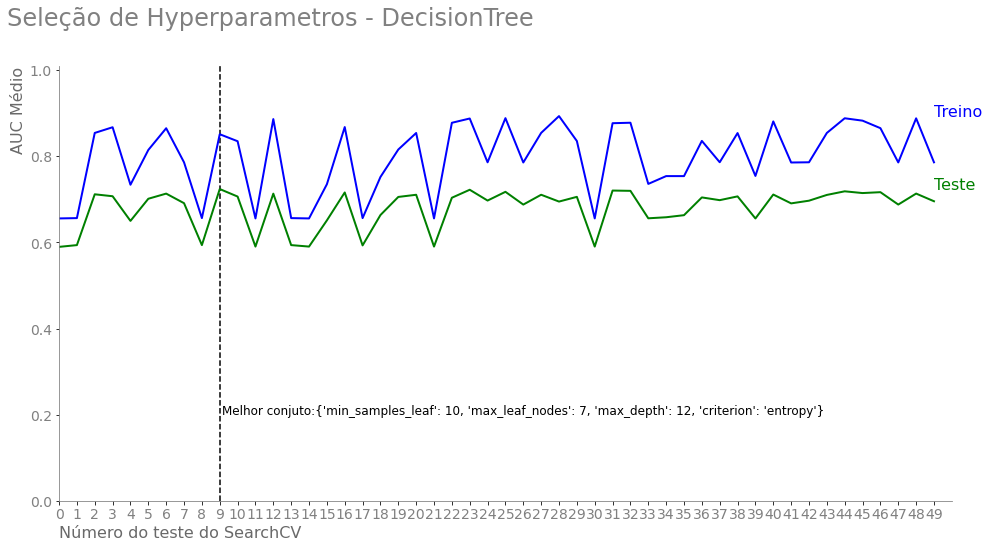

melhores hyperparametros : {'min_samples_leaf': 10, 'max_leaf_nodes': 7, 'max_depth': 12, 'criterion': 'entropy'}
Melhor modelo            : DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=12, max_features=None, max_leaf_nodes=7,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


,paramentros,media_teste,media_treino,std_teste,std_treino,mean_fit_time,std_fit_time,mean_score_time,std_score_time,rank_test_score
0,"{'min_samples_leaf': 2, 'max_leaf_nodes': 2, '...",0.589745,0.655798,0.039475,0.013107,0.003462,0.000456,0.002016,0.000258,50
1,"{'min_samples_leaf': 2, 'max_leaf_nodes': 7, '...",0.593843,0.656560,0.040702,0.012485,0.002504,0.000503,0.002054,0.000359,42
2,"{'min_samples_leaf': 2, 'max_leaf_nodes': 7, '...",0.711852,0.854367,0.054958,0.013123,0.003799,0.000258,0.002103,0.000329,13
3,"{'min_samples_leaf': 1, 'max_leaf_nodes': 8, '...",0.707343,0.867570,0.054344,0.012493,0.003938,0.000415,0.002109,0.000293,18
4,"{'min_samples_leaf': 3, 'max_leaf_nodes': 3, '...",0.650084,0.734056,0.054694,0.017275,0.003893,0.000130,0.002190,0.000472,41
5,"{'min_samples_leaf': 1, 'max_leaf_nodes': 5, '...",0.701502,0.814833,0.063379,0.015244,0.004777,0.000474,0.002176,0.000372,25
6,"{'min_samples_leaf': 8, 'max_leaf_nodes': 9, '...",0.713448,0.865251,0.070279,0.013255,0.003437,0.000222,0.001989,0.000140,11
7,"{'min_samples_leaf': 7, 'max_leaf_nodes': 4, '...",0.691213,0.786052,0.056327,0.015519,0.004143,0.000378,0.002099,0.000313,31
8,"{'min_samples_leaf': 1, 'max_leaf_nodes': 2, '...",0.593843,0.656560,0.040702,0.012485,0.002784,0.000337,0.002001,0.000438,42
9,"{'min_samples_leaf': 10, 'max_leaf_nodes': 7, ...",0.724056,0.851334,0.064910,0.016999,0.004546,0.000304,0.002086,0.000188,1


In [118]:
parameters = {'max_depth'       : np.arange(1, 21),
              'criterion'       : ['gini', 'entropy'],
              'min_samples_leaf': np.arange(1, 6),
              'max_leaf_nodes'  : np.arange(2, 6)
             }
modelo = DecisionTreeClassifier()

resultados, melhor_modelo_arvore, melhores_hyperparametros  = treina_modelo_randomized_search_cv(modelo,
                                                                                                  x_cv,
                                                                                                  y_cv,
                                                                                                  parameters,
                                                                                                  n_splits=5,
                                                                                                  n_repeats=10,
                                                                                                  n_iter=50,
                                                                                                  seed=14715)
plota_treino_teste_auc('Seleção de Hyperparametros - DecisionTree', 
                       resultados['media_teste'],
                       resultados['media_treino'],
                       resultados['rank_test_score'],
                       melhores_hyperparametros)

resultados_treinamento(resultados, melhor_modelo_arvore, melhores_hyperparametros, n = 10)

---
## 4.4) Forest Tree

> Aqui será treinado do modelo **Forest Tree**. No treino foi usado **RandomizedSearchCV** com **10** iterações. Os hyperparametros foram:
* n_estimators    : [10, 50, 100, 150, 200]
* max_depth       : [1, 20]    
* criterion       : [gini, entropy]
* min_samples_leaf: [1-5]
* max_leaf_nodes  : [2-5]


Fitting 50 folds for each of 50 candidates, totalling 2500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2500 out of 2500 | elapsed:  8.2min finished


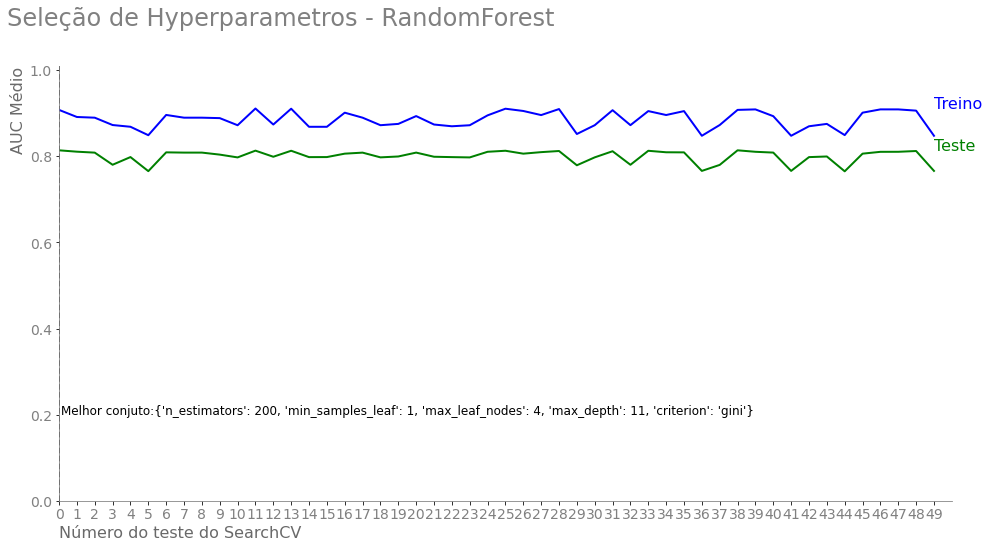

melhores hyperparametros : {'n_estimators': 200, 'min_samples_leaf': 1, 'max_leaf_nodes': 4, 'max_depth': 11, 'criterion': 'gini'}
Melhor modelo            : RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=11, max_features='auto',
                       max_leaf_nodes=4, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


,paramentros,media_teste,media_treino,std_teste,std_treino,mean_fit_time,std_fit_time,mean_score_time,std_score_time,rank_test_score
0,"{'n_estimators': 200, 'min_samples_leaf': 1, '...",0.813984,0.907871,0.050214,0.007114,0.305317,0.007283,0.019910,0.003412,1
1,"{'n_estimators': 150, 'min_samples_leaf': 4, '...",0.810814,0.891382,0.050779,0.007986,0.225822,0.004843,0.014575,0.001301,10
2,"{'n_estimators': 100, 'min_samples_leaf': 2, '...",0.808614,0.889778,0.050804,0.008566,0.151332,0.004816,0.011314,0.002192,23
3,"{'n_estimators': 10, 'min_samples_leaf': 2, 'm...",0.780455,0.872723,0.051329,0.013137,0.018298,0.001526,0.003492,0.000453,42
4,"{'n_estimators': 100, 'min_samples_leaf': 2, '...",0.798302,0.868683,0.053586,0.010023,0.142923,0.004987,0.010615,0.001091,33
5,"{'n_estimators': 10, 'min_samples_leaf': 3, 'm...",0.765613,0.849080,0.055286,0.016096,0.018772,0.001586,0.003400,0.000174,49
6,"{'n_estimators': 200, 'min_samples_leaf': 2, '...",0.809268,0.896143,0.051389,0.007993,0.318742,0.007872,0.019035,0.002775,17
7,"{'n_estimators': 100, 'min_samples_leaf': 1, '...",0.808684,0.889792,0.050808,0.008571,0.153110,0.005177,0.011261,0.001978,21
8,"{'n_estimators': 100, 'min_samples_leaf': 1, '...",0.808684,0.889792,0.050808,0.008571,0.152639,0.005244,0.010653,0.000922,21
9,"{'n_estimators': 50, 'min_samples_leaf': 3, 'm...",0.804006,0.888754,0.050864,0.009990,0.082264,0.003517,0.006805,0.000989,28


In [117]:
from sklearn.ensemble import RandomForestClassifier

parameters = {'n_estimators'    : [10, 50, 100, 150, 200],
              'max_depth'       : np.arange(1, 21),
              'criterion'       : ['gini', 'entropy'],
              'min_samples_leaf': np.arange(1, 5),
              'max_leaf_nodes'  : np.arange(2, 5)
             }
modelo = RandomForestClassifier(random_state=0)

resultados, melhor_modelo_forest, melhores_hyperparametros  = treina_modelo_randomized_search_cv(modelo,
                                                                                                  x_cv,
                                                                                                  y_cv,
                                                                                                  parameters,
                                                                                                  n_splits=5,
                                                                                                  n_repeats=10,
                                                                                                  n_iter=50,
                                                                                                  seed=14715)

plota_treino_teste_auc('Seleção de Hyperparametros - RandomForest', 
                       resultados['media_teste'],
                       resultados['media_treino'],
                       resultados['rank_test_score'],
                       melhores_hyperparametros)

resultados_treinamento(resultados, melhor_modelo_forest, melhores_hyperparametros, n = 10)

> 

## 4.5) Support Vector Classification.

> Aqui será treinado do modelo **SVC**. No treino foi usado **RandomizedSearchCV** com **50** iterações. Os hyperparametros de busca foram
* kernel        : [linear, poly, rbf, sigmoid]
* C             : [0, 2]
* gamma         : [scale, auto]
* shrinking     : [True , False]

Fitting 50 folds for each of 50 candidates, totalling 2500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2500 out of 2500 | elapsed:  1.5min finished


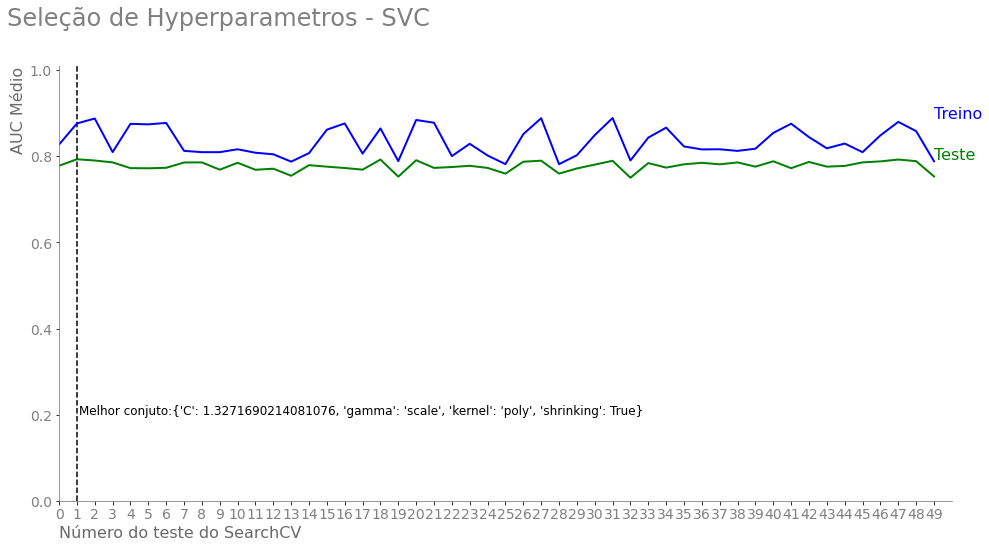

melhores hyperparametros : {'C': 1.3271690214081076, 'gamma': 'scale', 'kernel': 'poly', 'shrinking': True}
Melhor modelo            : SVC(C=1.3271690214081076, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='poly', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)


,paramentros,media_teste,media_treino,std_teste,std_treino,mean_fit_time,std_fit_time,mean_score_time,std_score_time,rank_test_score
0,"{'C': 1.4701863219523719, 'gamma': 'auto', 'ke...",0.778105,0.827322,0.053041,0.011249,0.028695,0.001978,0.003950,0.000758,25
1,"{'C': 1.3271690214081076, 'gamma': 'scale', 'k...",0.793250,0.876336,0.051393,0.010020,0.018080,0.001032,0.003132,0.000369,1
2,"{'C': 1.8813554402370531, 'gamma': 'scale', 'k...",0.790315,0.887844,0.051717,0.009850,0.018179,0.001660,0.003153,0.000429,5
3,"{'C': 0.872565127799168, 'gamma': 'auto', 'ker...",0.785947,0.809865,0.054960,0.011877,0.021183,0.001146,0.003318,0.000247,15
4,"{'C': 1.5194866996222245, 'gamma': 'auto', 'ke...",0.772641,0.875480,0.055924,0.011250,0.022908,0.001341,0.002945,0.000177,37
5,"{'C': 1.375029228314785, 'gamma': 'auto', 'ker...",0.772233,0.874285,0.056589,0.011353,0.019255,0.001093,0.003044,0.000281,39
6,"{'C': 1.7923741955744268, 'gamma': 'scale', 'k...",0.773385,0.877638,0.056104,0.011163,0.024294,0.001274,0.002957,0.000165,33
7,"{'C': 1.206530015269424, 'gamma': 'auto', 'ker...",0.785723,0.812748,0.055184,0.012200,0.020618,0.000655,0.003282,0.000378,17
8,"{'C': 0.010175292060016439, 'gamma': 'scale', ...",0.785972,0.809691,0.054831,0.011741,0.021016,0.000749,0.003246,0.000109,13
9,"{'C': 1.8515891573884744, 'gamma': 'auto', 'ke...",0.769033,0.809689,0.054032,0.012134,0.028338,0.002524,0.003637,0.000402,43


In [94]:
from sklearn.svm import SVC

parameters = {'kernel'          : ['linear', 'poly', 'rbf', 'sigmoid'],
              'C'               : uniform(loc=0, scale=2),
              'gamma'           : ['scale', 'auto'],
              'shrinking'       : [True, False]
             }

modelo = SVC(probability=True)

resultados, melhor_modelo_svc, melhores_hyperparametros  = treina_modelo_randomized_search_cv(modelo,
                                                                                                  x_cv,
                                                                                                  y_cv,
                                                                                                  parameters,
                                                                                                  n_splits=5,
                                                                                                  n_repeats=10,
                                                                                                  n_iter=50,
                                                                                                  seed=14715)

plota_treino_teste_auc('Seleção de Hyperparametros - SVC', 
                       resultados['media_teste'],
                       resultados['media_treino'],
                       resultados['rank_test_score'],
                       melhores_hyperparametros)

resultados_treinamento(resultados, melhor_modelo_svc, melhores_hyperparametros, n = 10)

## 4.5) KNeighbors

> Aqui será treinado do modelo **KNeighbor**. No treino foi usado **RandomizedSearchCV** com **50** iterações. Os hyperparametros de busca foram
* n_neighbors   : [1, 10]
* p             : [1, 2]
* weights       : [uniform, distance]
* algorithm     : [auto, ball_tree, kd_tree, brute]

Fitting 50 folds for each of 50 candidates, totalling 2500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2500 out of 2500 | elapsed:   34.0s finished


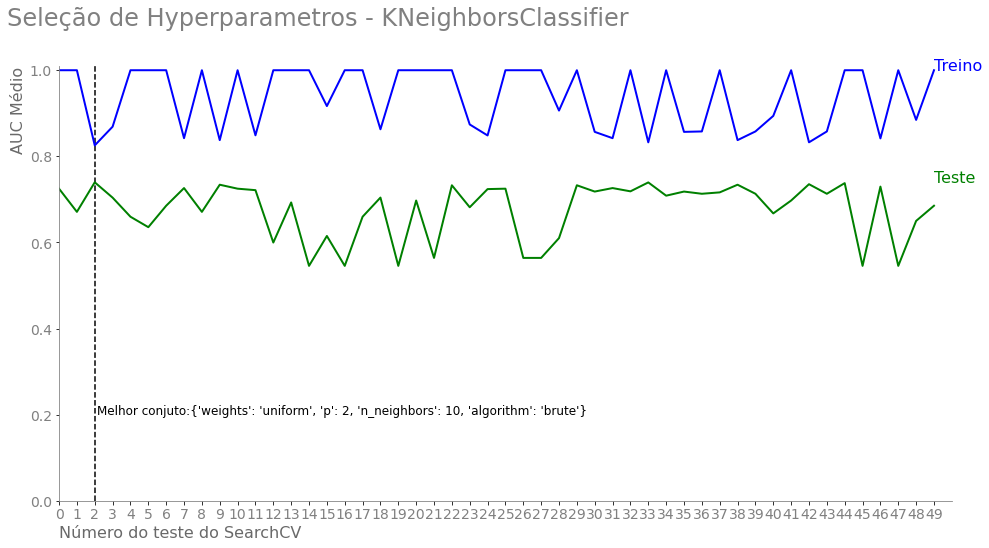

melhores hyperparametros : {'weights': 'uniform', 'p': 2, 'n_neighbors': 10, 'algorithm': 'brute'}
Melhor modelo            : KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')


,paramentros,media_teste,media_treino,std_teste,std_treino,mean_fit_time,std_fit_time,mean_score_time,std_score_time,rank_test_score
0,"{'weights': 'distance', 'p': 2, 'n_neighbors':...",0.724893,1.000000,0.057649,0.000000,0.002791,0.000722,0.004592,0.001806,12
1,"{'weights': 'distance', 'p': 2, 'n_neighbors':...",0.671058,1.000000,0.061922,0.000000,0.002731,0.001129,0.003939,0.000740,33
2,"{'weights': 'uniform', 'p': 2, 'n_neighbors': ...",0.739695,0.825470,0.059534,0.012708,0.002695,0.000424,0.004403,0.000775,1
3,"{'weights': 'uniform', 'p': 1, 'n_neighbors': ...",0.704071,0.868889,0.056240,0.011315,0.002665,0.000645,0.004153,0.000696,26
4,"{'weights': 'distance', 'p': 1, 'n_neighbors':...",0.659734,1.000000,0.066959,0.000000,0.002389,0.000191,0.003912,0.000477,36
5,"{'weights': 'distance', 'p': 2, 'n_neighbors':...",0.635497,1.000000,0.064206,0.000000,0.002435,0.000159,0.003786,0.000370,39
6,"{'weights': 'distance', 'p': 1, 'n_neighbors':...",0.685280,1.000000,0.063954,0.000000,0.002441,0.000282,0.003923,0.000356,30
7,"{'weights': 'uniform', 'p': 1, 'n_neighbors': ...",0.726304,0.842193,0.061075,0.011654,0.002415,0.000143,0.004088,0.000637,10
8,"{'weights': 'distance', 'p': 2, 'n_neighbors':...",0.671058,1.000000,0.061922,0.000000,0.002412,0.000232,0.003792,0.000401,33
9,"{'weights': 'uniform', 'p': 1, 'n_neighbors': ...",0.734098,0.837664,0.063417,0.012301,0.002390,0.000206,0.004029,0.000393,5


In [14]:
from sklearn.neighbors import KNeighborsClassifier

parameters = {'n_neighbors'     : np.arange(1, 11),
              'p'               : [1, 2],
              'weights'         : ['uniform', 'distance'],
              'algorithm'       : ['auto', 'ball_tree', 'kd_tree', 'brute']
             }

modelo = KNeighborsClassifier()

resultados, melhor_modelo_kn, melhores_hyperparametros  = treina_modelo_randomized_search_cv(modelo,
                                                                                                  x_cv,
                                                                                                  y_cv,
                                                                                                  parameters,
                                                                                                  n_splits=5,
                                                                                                  n_repeats=10,
                                                                                                  n_iter=50,
                                                                                                  seed=14715)

plota_treino_teste_auc('Seleção de Hyperparametros - KNeighborsClassifier', 
                       resultados['media_teste'],
                       resultados['media_treino'],
                       resultados['rank_test_score'],
                       melhores_hyperparametros)

resultados_treinamento(resultados, melhor_modelo_kn, melhores_hyperparametros, n = 10)

# 5) Avaliando o melhor modelo

> Agora vamos avaliar o melhor modelo encontrado utilizando o dados de validação.

In [96]:
modelos = [melhor_modelo_dummy, 
           melhor_modelo_lr, 
           melhor_modelo_arvore, 
           melhor_modelo_forest, 
           melhor_modelo_svc,
           melhor_modelo_kn] 

In [119]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

tns, fps, fns, tps, aucs, names = [], [], [], [], [], []
names
for modelo in modelos:
    name = type(modelo).__name__
    (tn, fp), (fn, tp) = confusion_matrix(y_val, modelo.predict(x_val))
    auc = roc_auc_score(y_val, modelo.predict_proba(x_val)[:, 1])
    tns.append(tn)
    fps.append(fp)
    fns.append(fn)
    tps.append(tp)
    aucs.append(auc)
    names.append(name)

modelos_desempenho = pd.DataFrame({'Name': names,
                                    'tn': tns,
                                    'fp': fps,
                                    'fn': fns,
                                    'tp': tps,
                                    'AUC': aucs
                                  }).sort_values('AUC', ascending=False, ignore_index=True)
modelos_desempenho

,Name,tn,fp,fn,tp,AUC
0,DecisionTreeClassifier,21,8,7,17,0.747845
1,RandomForestClassifier,20,9,8,16,0.745690
2,SVC,16,13,5,19,0.729885
3,LogisticRegression,17,12,8,16,0.719828
4,KNeighborsClassifier,23,6,13,11,0.684626
5,DummyClassifier,29,0,24,0,0.500000


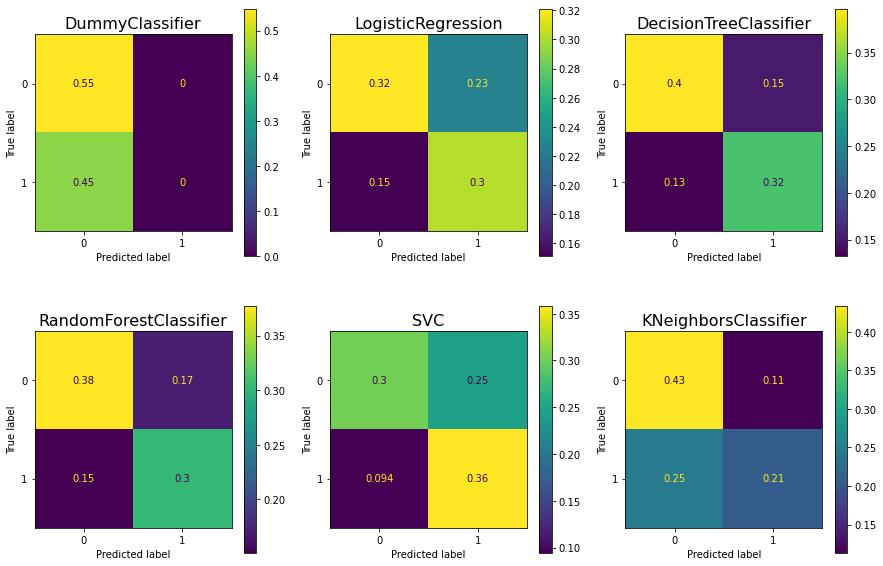

In [120]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

ax = ax.reshape(-1)

for i, modelo in enumerate(modelos):
    ax[i].set_title(type(modelo).__name__, fontsize=16)
    plot_confusion_matrix(modelo, x_val, y_val, ax=ax[i], normalize='all')


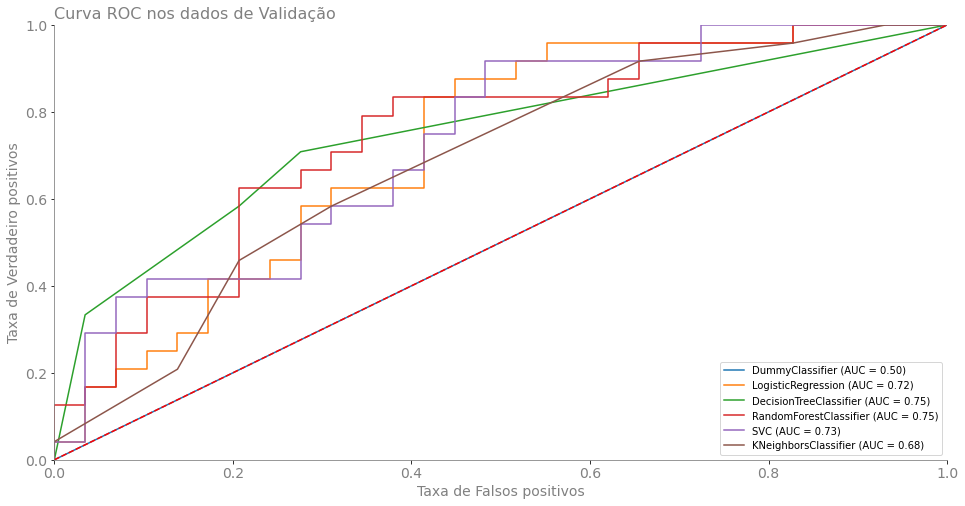

In [121]:
fig, ax = plt.subplots(figsize=(16,8))

fig.set_facecolor('white')
ax.set_facecolor('white')

ax.set_title('Curva ROC nos dados de Validação', loc = 'left', fontsize=16, color='gray')

for i, modelo in enumerate(modelos):
    plot_roc_curve(modelo , x_val, y_val, ax = ax) 
    
ax.plot([0, 1], [0, 1], color = "red", ls ='--')

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray')

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

plt.xticks(fontsize= 14, color='gray')
plt.yticks(fontsize= 14, color='gray')

ax.set_xlabel(xlabel= 'Taxa de Falsos positivos'   , fontsize=14, color='gray')
ax.set_ylabel(ylabel= 'Taxa de Verdadeiro positivos', fontsize=14, color='gray')

plt.show()

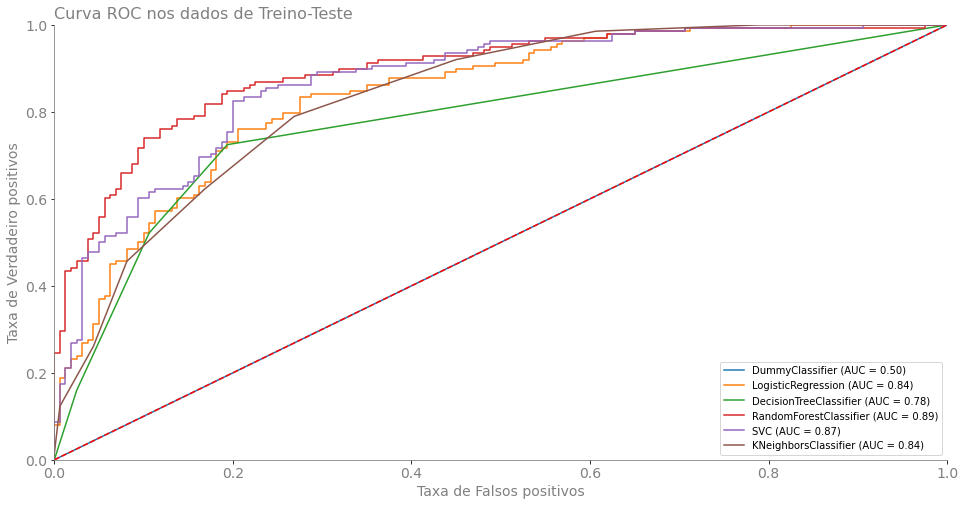

In [75]:
fig, ax = plt.subplots(figsize=(16,8))

fig.set_facecolor('white')
ax.set_facecolor('white')

ax.set_title('Curva ROC nos dados de Treino-Teste', loc = 'left', fontsize=16, color='gray')

for i, modelo in enumerate(modelos):
    plot_roc_curve(modelo , x_cv, y_cv, ax = ax) 
    
ax.plot([0, 1], [0, 1], color = "red", ls ='--')

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray')   

plt.xticks(fontsize= 14, color='gray')
plt.yticks(fontsize= 14, color='gray')

ax.set_xlabel(xlabel= 'Taxa de Falsos positivos'   , fontsize=14, color='gray')
ax.set_ylabel(ylabel= 'Taxa de Verdadeiro positivos', fontsize=14, color='gray')

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
plt.show()